## Import and file selection

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import imp
import pandas
import sys
from IPython.display import display

import matlab_tools as mt
import maze_tools as maze
import cv_tools as ct

imp.reload(maze)
imp.reload(mt)

python3 = sys.version_info > (3,0)

In [2]:
%matplotlib inline
hcpath='../_share/hc-5/'
hcpattern='_BehavElectrData.mat$'
ubpath='../_share/ubi_hpc_data/Data/'
ubpattern='spike_.*.dat$'
myfile=3 # 3, 7, 14

In [3]:
hcfile, hcdir, hcname = mt.mat_files(hcpath, hcpattern)
ubfile, ubdir, ubname = mt.mat_files(ubpath, ubpattern)
file = hcfile + ubfile
dir = hcdir + ubdir
name = hcname + ubname
mode = ['hc5'] * len(hcfile) + ['ubb'] * len(ubfile)
for i in range(0,len(file)):
    print (i, file[i], ('<--' if i==myfile else ''))

0 D:\KFKI\_share\hc-5\i01_maze05.005\i01_maze05_MS.005_BehavElectrData.mat 
1 D:\KFKI\_share\hc-5\i01_maze06.002\i01_maze06_MS.002_BehavElectrData.mat 
2 D:\KFKI\_share\hc-5\i01_maze06.005\i01_maze06_MS.005_BehavElectrData.mat 
3 D:\KFKI\_share\hc-5\i01_maze08.001\i01_maze08_MS.001_BehavElectrData.mat <--
4 D:\KFKI\_share\hc-5\i01_maze08.003\i01_maze08_MS.003_BehavElectrData.mat 
5 D:\KFKI\_share\hc-5\i01_maze08.004\i01_maze08_MS.004_BehavElectrData.mat 
6 D:\KFKI\_share\hc-5\i01_maze13.002\i01_maze13_MS.002_BehavElectrData.mat 
7 D:\KFKI\_share\hc-5\i01_maze13.003\i01_maze13_MS.003_BehavElectrData.mat 
8 D:\KFKI\_share\hc-5\i01_maze15.001\i01_maze15_MS.001_BehavElectrData.mat 
9 D:\KFKI\_share\hc-5\i01_maze15.002\i01_maze15_MS.002_BehavElectrData.mat 
10 D:\KFKI\_share\ubi_hpc_data\Data\spike_C1.dat 
11 D:\KFKI\_share\ubi_hpc_data\Data\spike_D1_L1.dat 
12 D:\KFKI\_share\ubi_hpc_data\Data\spike_D1_L16.dat 
13 D:\KFKI\_share\ubi_hpc_data\Data\spike_D1_L2.dat 
14 D:\KFKI\_share\ubi_hpc_d

In [4]:
imp.reload(mt)
imp.reload(maze)
mq = maze.maze_query(file[myfile], mode=mode[myfile])
available_laps = (mq.Par.BehavType==1) & (mq.Par.TrialType<=2)

print (mq.Laps.taskType, mq.Par.NLap)
print (available_laps)

LRalternation 28
[False  True  True  True  True  True  True False False  True  True  True
 False False  True False  True False  True  True  True  True  True  True
  True  True  True  True]


## Linearize the maze
(The data included in the .mat files is not  consistent between sessions)

[ 523.39712342  395.01597299   17.98260737   15.27054175]
[   44.9057736   1050.49446438    85.27066596     9.58298789    17.59340508]


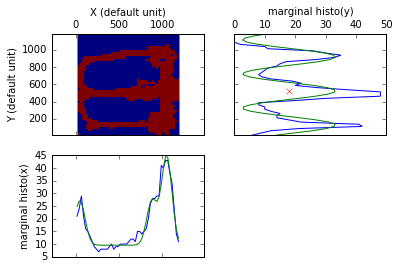

In [5]:
mq.fit_track(True)

[ 242.41376009  852.98647788] [ 523.39712342]
[   45.9057736   1049.49446438] [ 524.39712342  522.39712342]


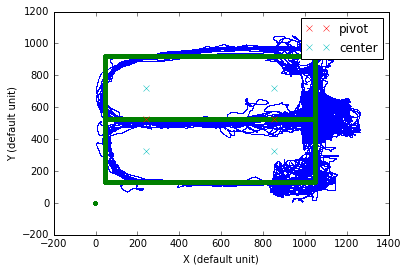

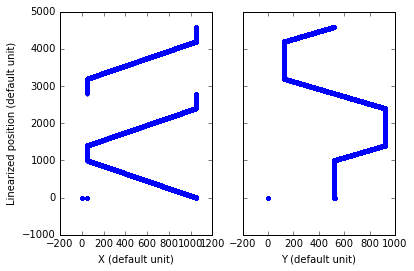

In [6]:
mq.linearize_tracks(True)

## Calculate place fields

In [7]:
import time
binmm = 50
div2 = mq.propose_bins(binmm)
div1 = mq.propose_bins(binmm,dim=1)
nam2 = name[myfile].replace('.mat','').replace('.dat','')+'_placefield2_%d.mat' % binmm
nam1 = name[myfile].replace('.mat','').replace('.dat','')+'_placefield1_%d.mat' % binmm
prog_update = 1462789534
print ("%.0f"%time.time())

1463495912


In [8]:
import os
if os.path.isfile(nam2) and (os.path.getmtime(nam2)>=prog_update):
    stat2 = maze.PlaceField()
    stat2.__dict__ = sio.loadmat(nam2)
else:
    stat2 = mq.get_2d_place_field((div2,div2),'proj%s') # 'lin%s' '%s'
    sio.savemat(nam2,stat2.__dict__)
if os.path.isfile(nam1) and (os.path.getmtime(nam1)>=prog_update):
    stat1 = maze.PlaceField()
    stat1.__dict__ = sio.loadmat(nam1,squeeze_me=True)
else:
    stat1 = mq.get_1d_place_field(div1,'proj%s') # 'lin%s' '%s'
    sio.savemat(nam1,stat1.__dict__)


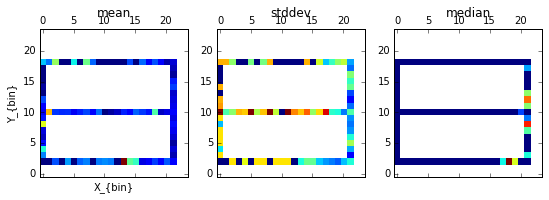

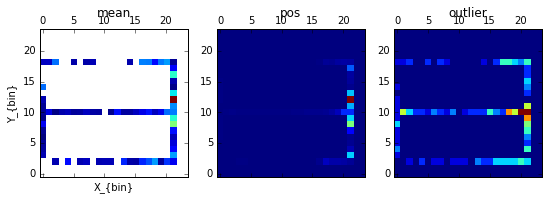

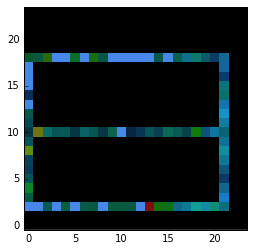

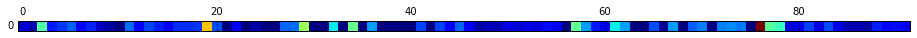

In [9]:
clust = 11
relstd = np.divide(stat2.std[clust],stat2.mean[clust])
relstd[stat2.std[clust]==0] = 0
#v = mq._maze_query__project_bins((div2,div2))

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
ax1.matshow(mt.adjust_series(stat2.mean[clust].T),origin='lower')
ax1.set_xlabel('X_{bin}')
ax1.set_ylabel('Y_{bin}')
ax1.set_title('mean')
ax2.matshow(mt.adjust_series(relstd.T),origin='lower')
ax2.set_title('stddev')
ax3.matshow(mt.adjust_series(stat2.median[clust].T),origin='lower')
ax3.set_title('median')
plt.show()

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
ax1.matshow(mt.adjust_series(stat2.info_mean[clust].T),origin='lower')
ax1.set_xlabel('X_{bin}')
ax1.set_ylabel('Y_{bin}')
ax1.set_title('mean')
ax2.matshow(mt.adjust_series(stat2.p_x_.T),origin='lower')
ax2.set_title('pos')
ax3.matshow(mt.adjust_series(stat2.outlier[clust].T),origin='lower')
ax3.set_title('outlier')
plt.show()

img = mt.hls_matrix(0.60*mt.adjust_series(-stat2.mean[clust]),0.6/(1+3*mt.adjust_series(relstd)),0.8) 
plt.imshow(img,interpolation='none',origin='lower')
plt.show()

img = stat1.mean[clust]
plt.matshow(mt.adjust_series(img[np.newaxis,:]))
plt.show()

## Show place fields

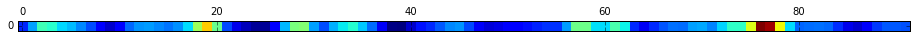

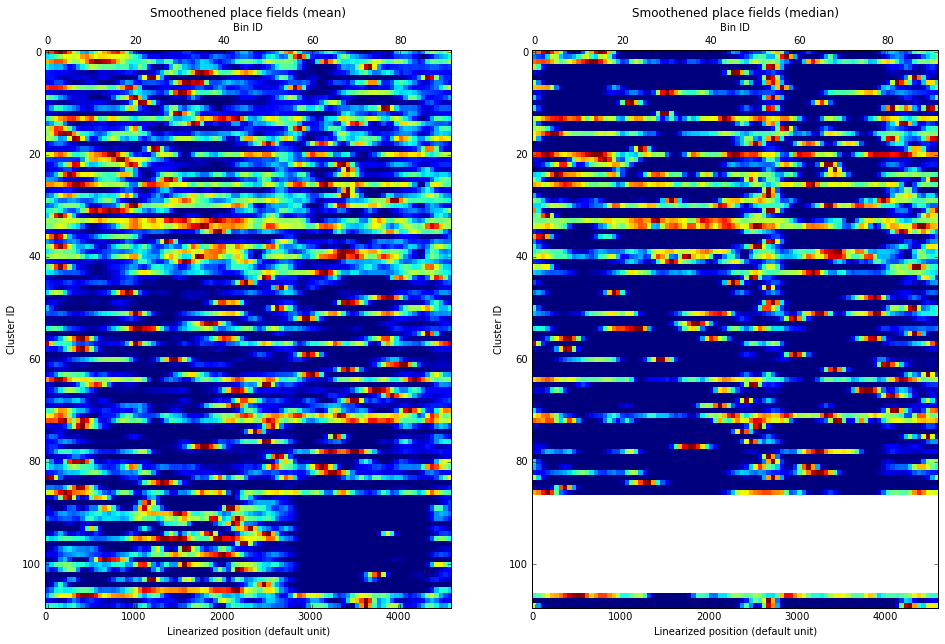

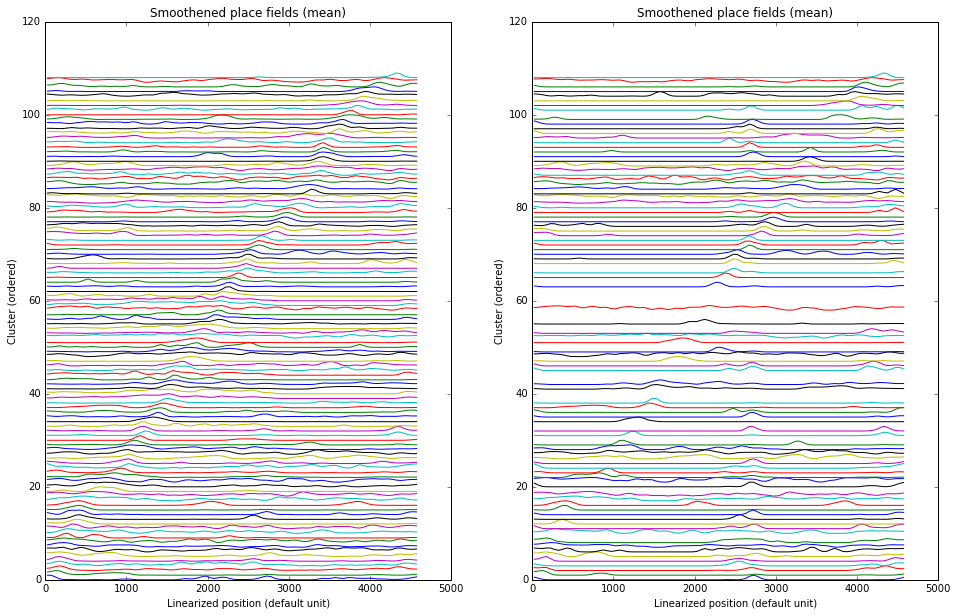

In [10]:
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import gaussian
import copy
# sigma of the gaussian window in #bins

window_width = 1
stat0 = copy.deepcopy(stat1)

# Method A
##stat0.mean = gaussian(stat.mean,sigma=(0,window_width))
##stat0.mean = [np.convolve(v,gw,mode='same') for v in stat0.mean]
# Method B
stat0.mean = np.array([gaussian_filter(v.astype(float),window_width) for v in stat0.mean])
stat0.median = np.array([gaussian_filter(v.astype(float),window_width) for v in stat0.median])
# Alternative normalization
#stat0.mean = np.array([v*s/(1e-3+np.max(v)) for v, s in zip(stat0.mean, np.nanmax(stat1.mean,axis=1))])
#stat0.median = np.array([v*s/(1e-3+np.max(v)) for v, s in zip(stat0.median, np.nanmax(stat1.median,axis=1))])

### One example
img = stat0.mean[clust]
plt.matshow(mt.adjust_series(img[np.newaxis,:]))
plt.show()

### Heatmaps
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,10))#,sharey='row')
ax1p = ax1.twiny()
img = stat0.mean
ax1.set_title("Smoothened place fields (mean)")
ax1.matshow(mt.adjust_series(img,axis=1),aspect='auto')
ax1.set_ylabel("Cluster ID")
ax1.set_xlabel("Bin ID")
ax1.xaxis.set_label_position('top')
ax1p.set_xlabel("Linearized position (default unit)")
ax1p.set_xlim(div1[[0,-1]])
ax1p.xaxis.set_label_position('bottom')
ax1p.xaxis.set_ticks_position('bottom')

ax2p = ax2.twiny()
img = stat0.median
ax2.set_title("Smoothened place fields (median)")
ax2.matshow(mt.adjust_series(img,axis=1),aspect='auto')
ax2.set_ylabel("Cluster ID")
ax2.set_xlabel("Bin ID")
ax2.xaxis.set_label_position('top')
ax2p.set_xlabel("Linearized position (default unit)")
ax2p.set_xlim(div1[[0,-1]])
ax2p.xaxis.set_label_position('bottom')
ax2p.xaxis.set_ticks_position('bottom')
plt.show()

### Seizmic plots, TODO: apply ordering
pf_ordering1 = np.argsort(np.argmax(stat0.mean, axis=1))
pf_ordering2 = np.argsort(np.argmax(stat0.median, axis=1))

step = 1.0
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,10))#,sharey='row')
img = mt.adjust_series(stat0.mean,axis=1)
nDims = img.shape[0]
for i in range(0,nDims):
    ax1.plot(0.5*(div1[:-1]+div1[1:]),img[pf_ordering1[i],:]+step*i)
ax1.set_title("Smoothened place fields (mean)")
ax1.set_ylabel("Cluster (ordered)")
ax1.set_xlabel("Linearized position (default unit)")

img = mt.adjust_series(stat0.median,axis=1)
nDims = img.shape[0]
for i in range(0,nDims):
    ax2.plot(0.5*(div1[:-1]+div1[1:]),img[pf_ordering1[i],:]+step*i)
ax2.set_title("Smoothened place fields (mean)")
ax2.set_ylabel("Cluster (ordered)")
ax2.set_xlabel("Linearized position (default unit)")
plt.show()

# Compare old and new peak values
#print (np.column_stack((np.nanmax(stat0.mean,axis=1),np.nanmax(stat1.mean,axis=1))))

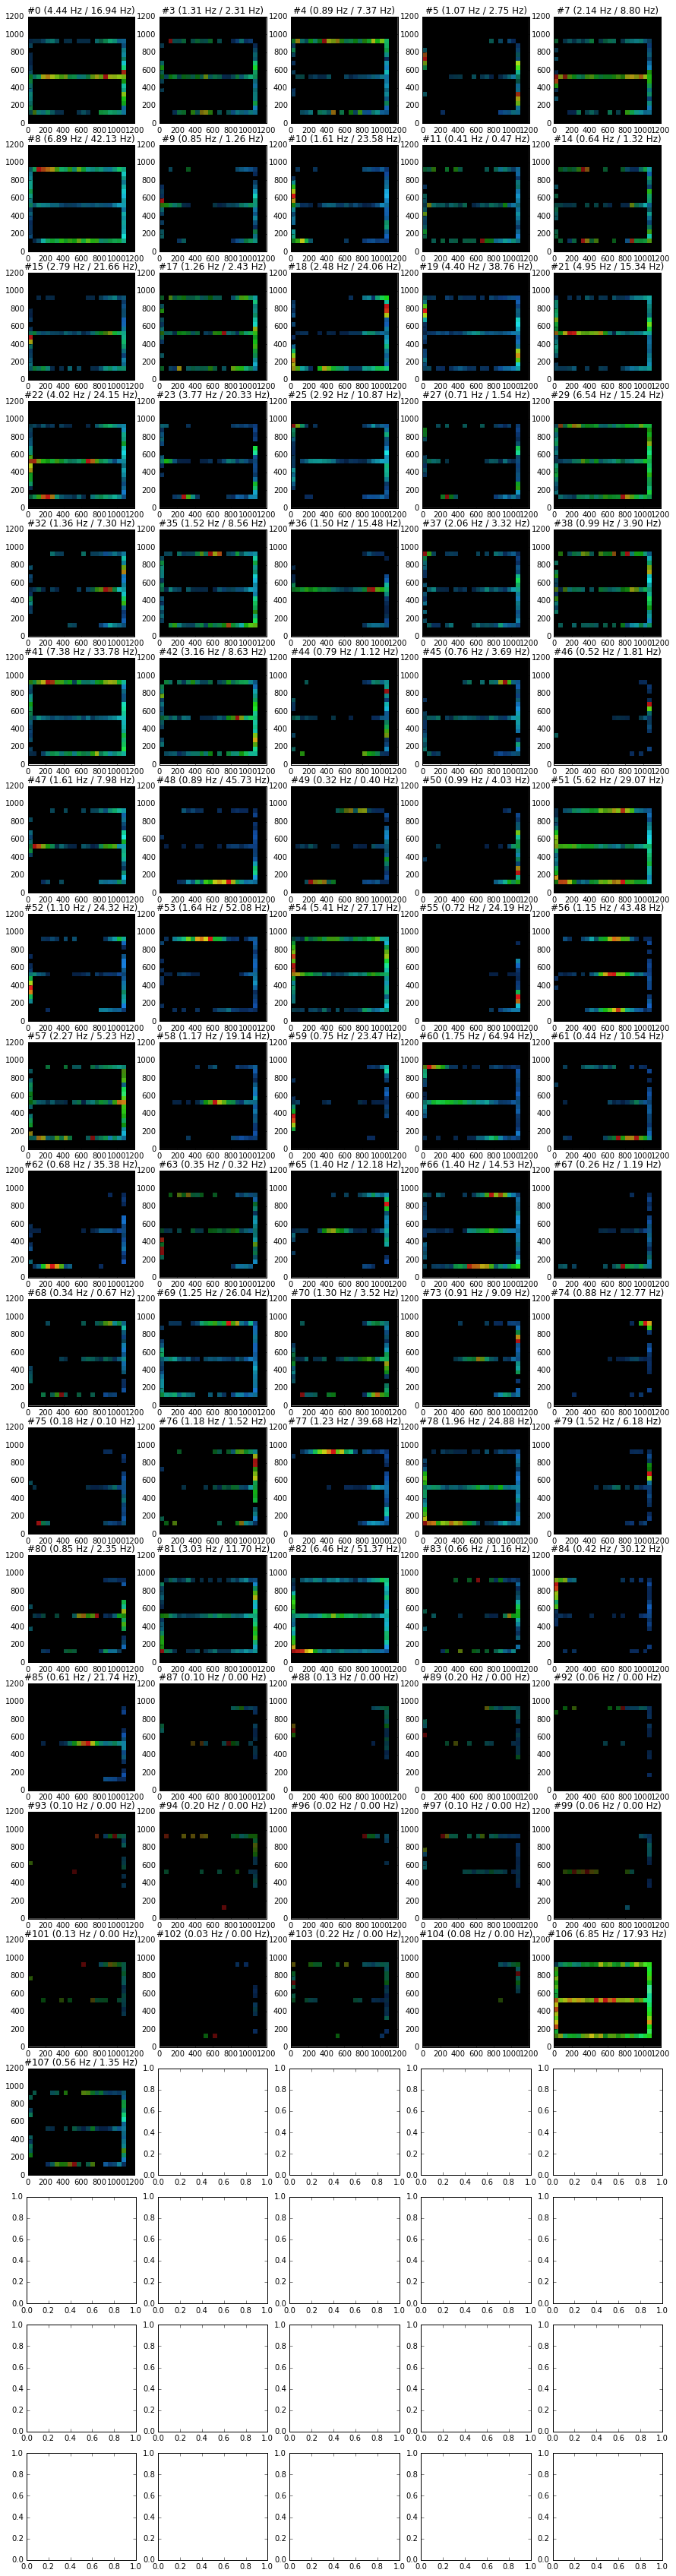

In [13]:
f, ax = plt.subplots(20,5,figsize=(15,60))
neu = mq.Clu.totClu-1
inn = mq.Clu.isIntern
idx = neu[~inn.astype(bool)]
n = len(idx)
for i in range(0,n):
    clust = idx[i]
    relstd = np.divide(stat2.std[clust],stat2.mean[clust])
    relstd[stat2.std[clust]==0] = 0
    x, y = i%5, int(i/5)
    img = mt.hls_matrix(0.60*(1-mt.shrink_series(stat2.mean[clust])),
                        0.6*mt.crop_series(2*stat2.info_mean[clust],(0,1))/(1+3*mt.adjust_series(relstd)),
                        0.8) 
    ax[y,x].imshow(img,interpolation='none',origin='lower',extent=(div2[[0,-1,0,-1]]))
    avg_rate = np.nanmean(stat2.rate[clust])
    peak_rate = np.nanmax(stat2.median[clust])
    ax[y,x].set_title('#%d (%.2f Hz / %.2f Hz)'%(clust,avg_rate,peak_rate))
plt.show()

# Bayesian decoding of position

Length of a time bin is 0.200000 s


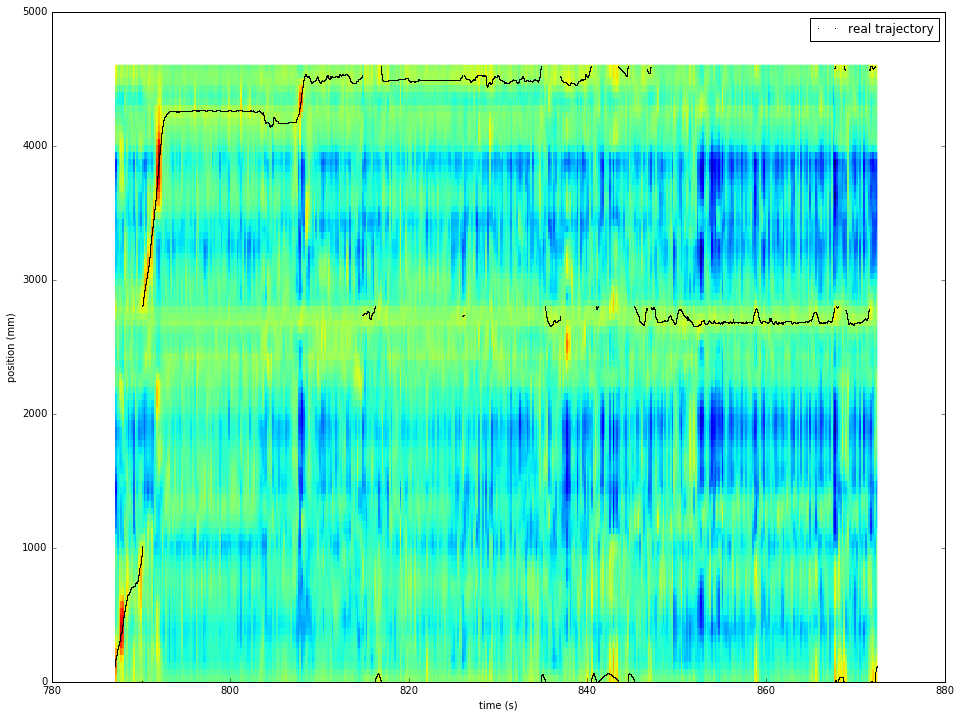

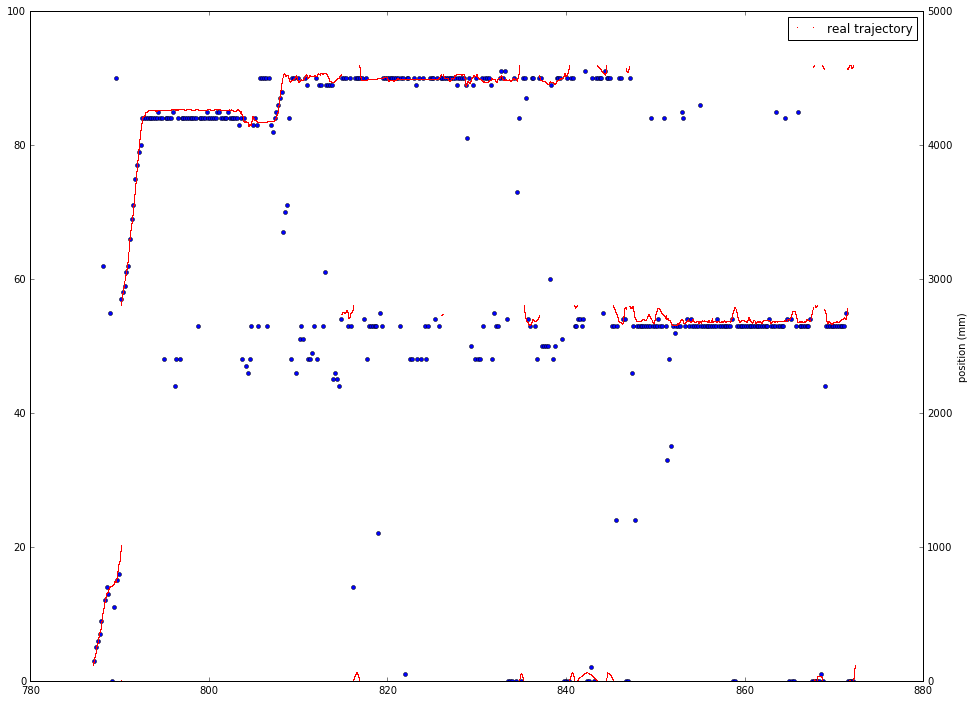

In [14]:
clust = 21
lap = 9
#tics = mq.get_intervals('mid_arm','mid_arm')
#tics = mq.get_intervals('mid_arm','lat_arm')
#tics = mq.get_intervals('turn','turn')
#tics = mq.get_intervals('wheel','wheel')
tics = mq.get_intervals('all','all')
width = 250
duration = mq.tic_to_time(width)
print ("Length of a time bin is %f s"%duration)

tim, spk = mq.get_spike_counts(tics[lap,0],tics[lap,1],width)
pos = mq.get_fields(tics[lap,0],tics[lap,1],'projDist')
mean_rate = np.nanmedian(stat0.rate,axis=1)
peak_rate = np.nanmax(stat0.mean,axis=1)
px = stat0.p_x_

# parameter to correct average rate of the rarely iring neurons (choose carefully)
zero_corr = 0.1
isInt = mq.Clu.isIntern!=0
include = (peak_rate>1.) & (~isInt) & (mq.Clu.totClu < 100)
dec = maze.bayesian_decode(spk[include], stat0.mean[include] * duration + zero_corr,
                      stat0.p_x_/sum(stat0.p_x_), mean_rate[include] * duration + zero_corr)

f, ax = plt.subplots(figsize=(16,12))
if dec.ndim == 2:
    ext = mq.tic_to_time(tics[lap,0]), mq.tic_to_time(tics[lap,1]), div1[0], div1[-1]
    asp = (ext[1]-ext[0])/(ext[3]-ext[2])
    ax.matshow(mt.adjust_series(dec.T),origin='lower',extent=ext,aspect='auto')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('position (mm)')
    ax.plot(mq.tic_to_time(np.array(range(tics[lap,0],tics[lap,1]))),pos.T,',k',label='real trajectory')
else:
    dec = dec[0]
    ax.matshow(mt.adjust_series(dec.T))
plt.legend()
plt.show()

f, ax = plt.subplots(figsize=(16,12))
if dec.ndim == 2:
    ext = mq.tic_to_time(tics[lap,0]), mq.tic_to_time(tics[lap,1]), div1[0], div1[-1]
    #asp = (ext[1]-ext[0])/(ext[3]-ext[2])
    ax.plot(mq.tic_to_time((tim[1:]+tim[:-1])/2),np.argmax(dec.T,axis=0),'bo',ms=4,label='maximum likelihood')
    #ax.xaxis.set_ticks_position('bottom')
    axt = ax.twinx()
    axt.set_xlabel('time (s)')
    axt.set_ylabel('position (mm)')
    axt.plot(mq.tic_to_time(np.array(range(tics[lap,0],tics[lap,1]))),pos.T,',r',label='real trajectory')
else:
    dec = dec[0]
    ax.matshow(mt.adjust_series(dec.T))
plt.legend()
plt.show()

In [15]:
# TODO: see if there are wheel distance fields

## Visulaization of life signals

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


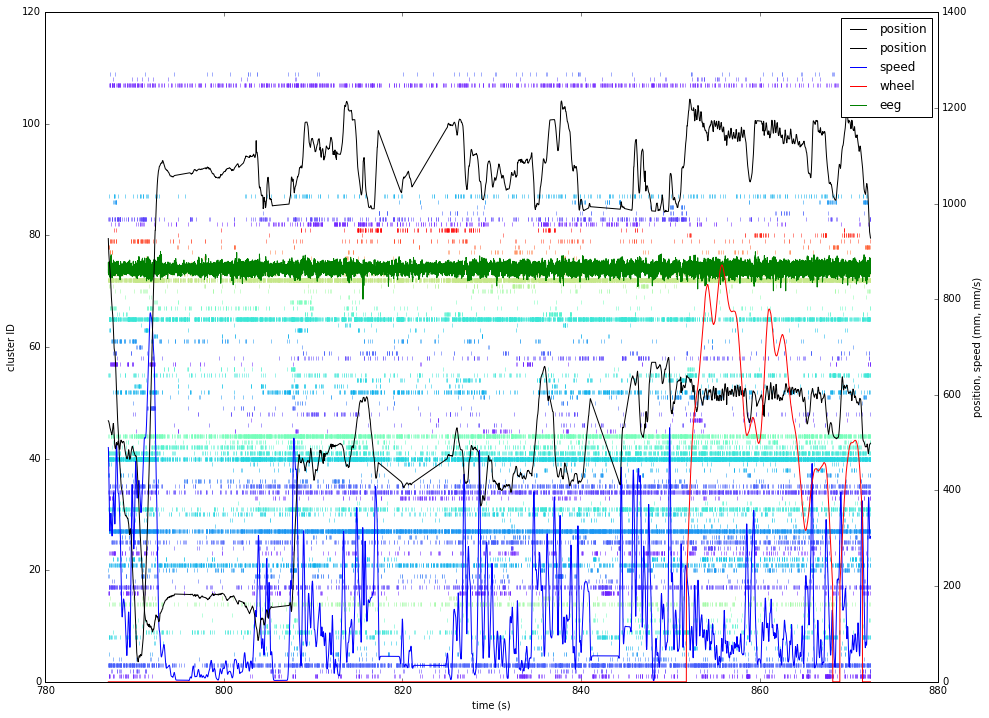

In [16]:
mq.visualize_spikes(tics[lap,0],tics[lap,1])

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


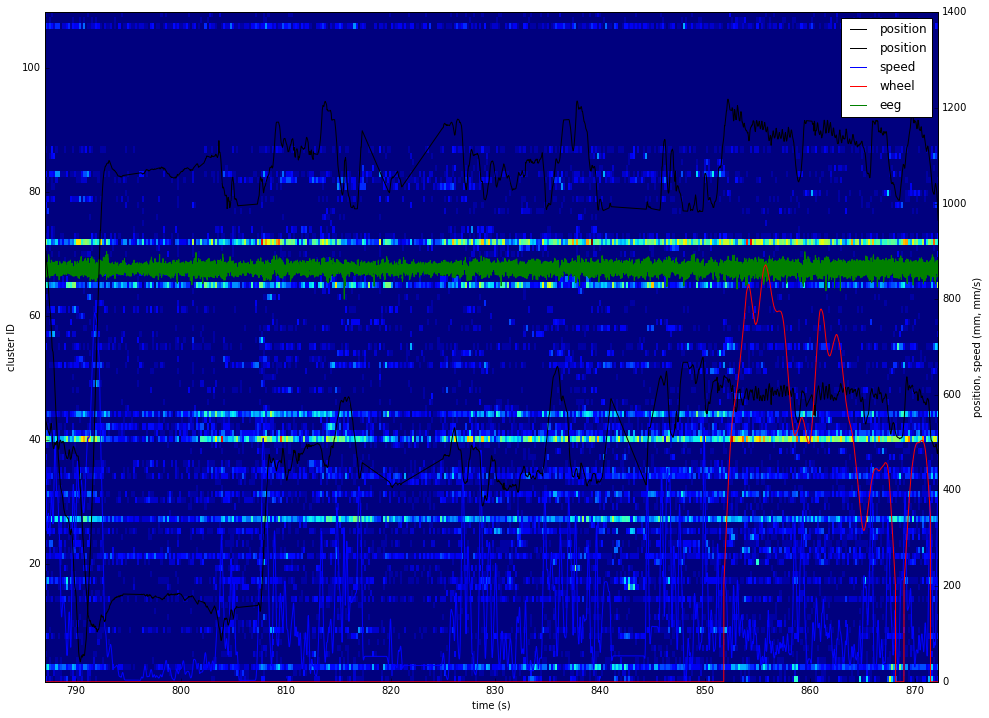

In [17]:
mq.visualize_counts(tics[lap,0],tics[lap,1],width)

In [18]:
peak_rate

array([ 13.63552749,  10.82581114,  39.57414249,   4.09839097,
         6.15323885,   3.16898728,   2.403687  ,   9.56309181,
        40.76297575,   3.17454441,  20.67968546,   2.40760115,
         9.629962  ,  13.09598634,   2.26165539,  15.19947699,
        22.26685493,   2.53102443,  21.7069892 ,  27.82864549,
        16.25261128,  15.0921043 ,  21.44192098,  17.64896296,
        20.15575194,   9.58562631,  53.89640821,   3.71047355,
         2.89535592,  14.26541073,  33.5344789 ,   1.69654027,
         8.56310385,  25.99526556,  16.4327059 ,   6.43964895,
        15.56727947,   5.12329693,   2.97268944,  89.45688323,
        27.8572748 ,  29.64426824,   7.32235357,  56.15807061,
         2.71178535,   6.43850392,   0.95131758,   7.25414665,
        34.07811364,   3.86006896,   2.93479098,  32.59052315,
        18.54486745,  40.91784967,  20.66967641,  13.3427402 ,
        35.04287403,   4.60463993,  15.02204465,  15.5115344 ,
        38.52347313,  10.13618453,  30.87421398,   1.92